#  Recognize Gundam's Mobile Suit  with SSD.

Recognize mobile suits that appear in Mobile Suit Gundam using Chainer CV's SSD.

In [1]:
import chainer
from chainercv.links import SSD300
from chainercv import utils

import pickle
import numpy as np
from pathlib import Path

from PIL import Image,ImageDraw

In [2]:
# draw bounding-box and label
def draw_bbox(img, bbox, labels, score, label_color, padding=1):
    dr = ImageDraw.Draw(img)
    for i,axiz in enumerate(bbox):
        label = list(label_color.keys())[labels[i]]
        axiz = np.int32(axiz)
        
        ms_name, ms_color = label_color[label]
        label_score = "{0} {1}, {2:2.2f}".format(label, ms_name , score[i])
        stp = (axiz[1],axiz[0])
        edp = (axiz[3],axiz[2])
        edp_back = (axiz[3],axiz[0]+10)
        
        rect = Image.new("RGB", (axiz[3]-axiz[1],axiz[2]-axiz[0]), color=ms_color)
        mask=Image.new('L', rect.size, color=64)
        img.paste(rect, stp , mask=mask)
        
        dr.rectangle((stp,edp_back),fill=ms_color)
        dr.rectangle((stp,edp),outline=ms_color)
        dr.rectangle(((stp[0]-padding, stp[1]-padding),(edp[0]+padding,edp[1]+padding)),outline=ms_color)
        
        stp_text = (axiz[1]+5,axiz[0])
        dr.text(stp_text, label_score)
    return img

In [3]:
# label & color file path
LABEL_FILE = Path("ms_label_color.pkl")

# test img file path
TEST_IMG_DIR = Path("test_image")

# test img file path
OUT_IMG_DIR = Path("output_image")

# pre-trained model file path
### download model file from here and put it in the current directory.
### https://drive.google.com/drive/folders/1L3KyEe_bc9LaFUmayfehCJ6qO35iupkj
MODEL_FILE = Path("gundam_ssd300")

# using gpu no
GPU_NUM = 0

In [4]:
# Loading label & color file
with open(LABEL_FILE, 'rb') as f:
    LABEL_NAME_COLOR_MAP = pickle.load(f)
LABEL_NAME_COLOR_MAP

{'MS-06': ['ZAKU II', (128, 0, 0)],
 'MS-07': ['GOUF', (0, 128, 0)],
 'MS-09': ['DOM', (128, 128, 0)],
 'MS-14': ['GELGOOG', (0, 0, 128)],
 'MS-15': ['GYAN', (128, 0, 128)],
 'MSM-03': ['GOGG', (0, 128, 128)],
 'MSM-04': ['ACGUY', (128, 128, 128)],
 'MSM-07': ['ZGOK', (64, 0, 0)],
 'MSN-02': ['ZEONG', (192, 0, 0)],
 'RGM-79': ['GM', (64, 128, 0)],
 'RX-75': ['GUNTANK', (192, 128, 0)],
 'RX-77': ['GUNCANON', (64, 0, 128)],
 'RX-78': ['GUNDAM', (192, 0, 128)]}

In [5]:
# Loading model weight
model = SSD300(n_fg_class=len(LABEL_NAME_COLOR_MAP), pretrained_model=MODEL_FILE)
if GPU_NUM >= 0:
    chainer.cuda.get_device_from_id(GPU_NUM).use()
    model.to_gpu()

In [6]:
test_img_path = list(TEST_IMG_DIR.glob("*"))
test_img_path

[WindowsPath('test_image/gundam_odaiba.jpg'),
 WindowsPath('test_image/gundam_v.jpg'),
 WindowsPath('test_image/sd-gundam.jpg')]

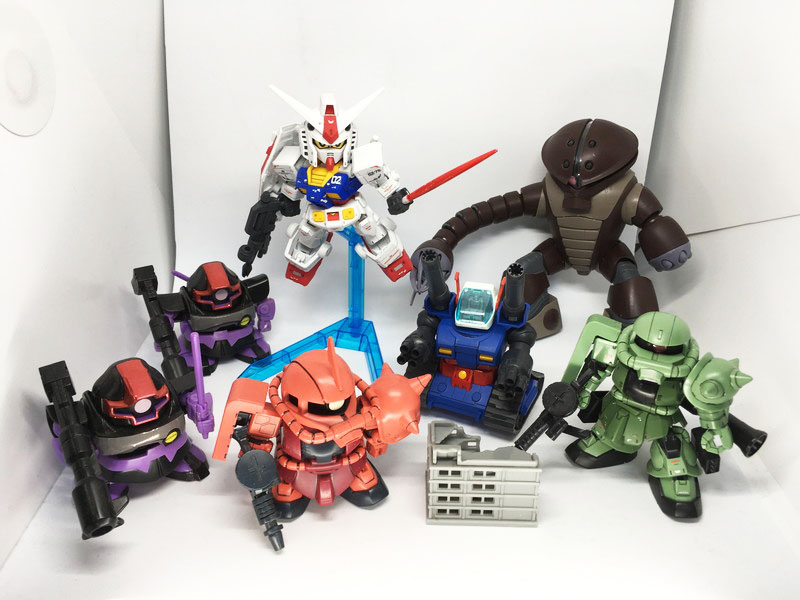

In [7]:
img_pil = Image.open(test_img_path[2])
img_pil

Wall time: 1.65 s


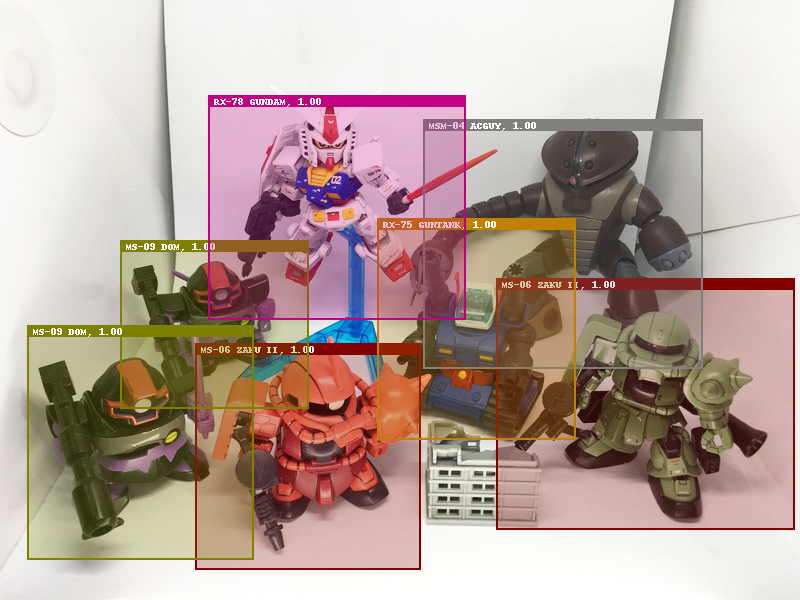

In [8]:
img_cv = np.float32(img_pil).transpose(2,0,1)
%time bboxes, labels, scores = model.predict([img_cv])
bbox, label, score = bboxes[0], labels[0], scores[0]

dist_img = draw_bbox(img_pil.copy(), bbox, label, score, LABEL_NAME_COLOR_MAP)
dist_img.save(OUT_IMG_DIR/Path(img_pil.filename).name)
dist_img